In [49]:
import numpy as np
import pandas as pd
import zipfile
import os
import shutil
from tqdm import tqdm
import torch
import torchvision
import matplotlib.pyplot as plt
import time
import copy
from torchvision import transforms, models

In [50]:
print(os.listdir('../input'),'\n') 
with zipfile.ZipFile('../input/platesv2/plates.zip', 'r') as zip_obj:
        zip_obj.extractall('/kaggle/working/') 
print(os.listdir('/kaggle/working/'))

data_root = '/kaggle/working/plates/' 
print(data_root)
print(os.listdir(data_root))

['platesv2'] 

['val', '__MACOSX', 'plates', '.virtual_documents', 'train']
/kaggle/working/plates/
['test', '.DS_Store', 'train']


In [51]:
data_root = '/kaggle/working/plates'

train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, train_dir, class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name)
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 21/21 [00:00<00:00, 3313.04it/s]


In [52]:
!ls train

cleaned  dirty


In [53]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.2, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size = batch_size, shuffle = True, num_workers = batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size = batch_size, shuffle = True, num_workers = batch_size)

In [54]:
len(train_dataloader), len(train_dataset)

(4, 32)

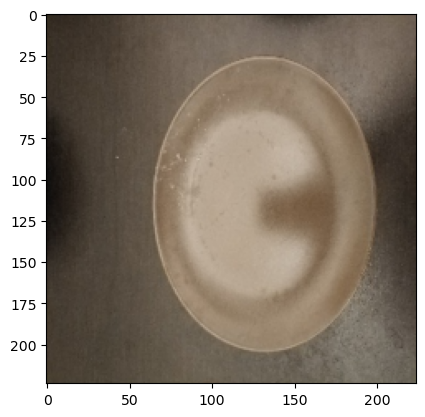

In [55]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean)

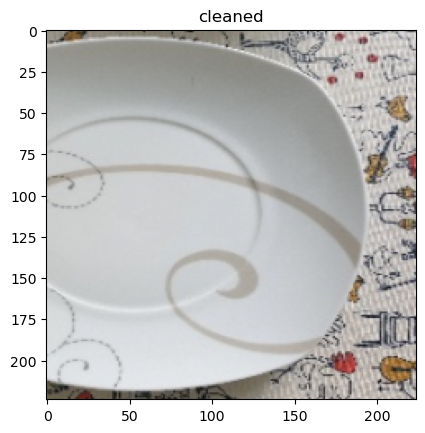

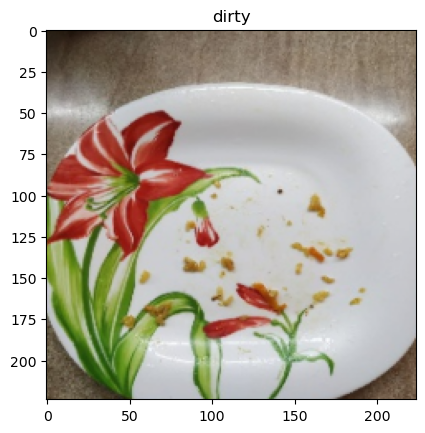

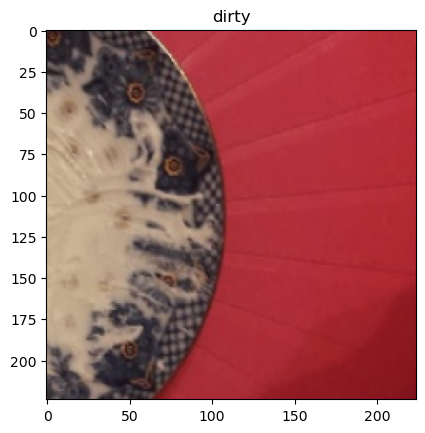

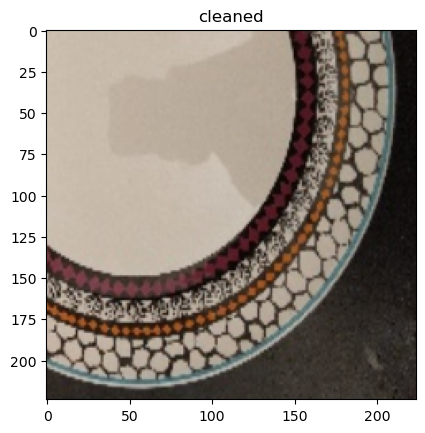

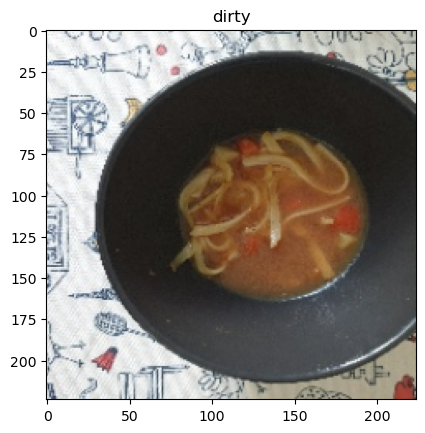

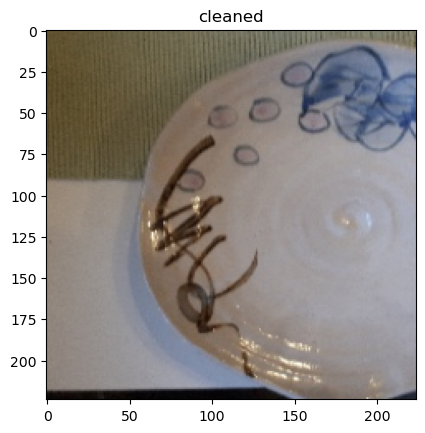

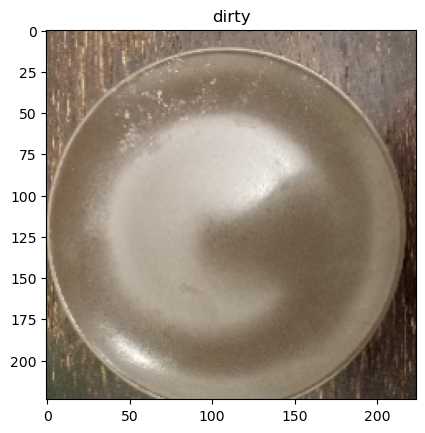

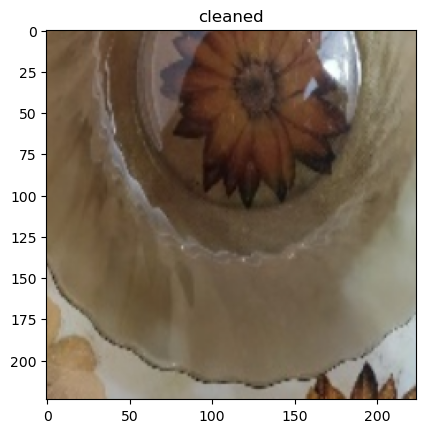

In [56]:
def show_input(input_tensor, title = ''):
    image = input_tensor.permute(1, 2, 0).numpy() * std + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)
    
X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [57]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    train_loss_hist, val_loss_hist = [], []
    train_acc_hist, val_acc_hist = [], []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                model.train()
            else:
                dataloader = val_dataloader
                model.eval()
                
            running_loss = 0.0
            running_acc = 0.0
            
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)
                    
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()
                        
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()
                
            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            if phase == 'train':
                train_loss_hist.append(epoch_loss)
                train_acc_hist.append(epoch_acc.detach().cpu())
                scheduler.step()
            else:
                val_loss_hist.append(epoch_loss)
                val_acc_hist.append(epoch_acc.detach().cpu())
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
    
    plt.plot(train_loss_hist, label='train')
    plt.plot(val_loss_hist, label='val')
    plt.legend()
    plt.show()
    plt.plot(train_acc_hist, label='train')
    plt.plot(val_acc_hist, label='val')
    plt.legend()
    plt.show()
    return model

In [58]:
model = models.resnet18(weights = models.ResNet18_Weights.IMAGENET1K_V1)

for param in model.parameters():
    param.requires_grad = False
    
model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr = 1.0e-3)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

Epoch 0/49:


100%|██████████| 4/4 [00:00<00:00,  6.59it/s]


train Loss: 0.8814 Acc: 0.3750


100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

val Loss: 0.6786 Acc: 0.6250
Epoch 1/49:



100%|██████████| 4/4 [00:00<00:00,  7.06it/s]


train Loss: 0.7489 Acc: 0.5000


100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

val Loss: 0.6418 Acc: 0.5000
Epoch 2/49:



100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


train Loss: 0.6978 Acc: 0.5625


100%|██████████| 1/1 [00:00<00:00,  2.07it/s]

val Loss: 0.6489 Acc: 0.5000
Epoch 3/49:



100%|██████████| 4/4 [00:00<00:00,  6.83it/s]


train Loss: 0.6512 Acc: 0.6250


100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

val Loss: 0.6581 Acc: 0.6250
Epoch 4/49:



100%|██████████| 4/4 [00:00<00:00,  6.78it/s]


train Loss: 0.6143 Acc: 0.6562


100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

val Loss: 0.6536 Acc: 0.6250
Epoch 5/49:



100%|██████████| 4/4 [00:00<00:00,  6.90it/s]


train Loss: 0.5253 Acc: 0.7500


100%|██████████| 1/1 [00:00<00:00,  2.23it/s]

val Loss: 0.6074 Acc: 0.7500
Epoch 6/49:



100%|██████████| 4/4 [00:00<00:00,  6.87it/s]


train Loss: 0.4533 Acc: 0.7812


100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


val Loss: 0.5807 Acc: 0.8750
Epoch 7/49:


100%|██████████| 4/4 [00:00<00:00,  6.61it/s]


train Loss: 0.4722 Acc: 0.8438


100%|██████████| 1/1 [00:00<00:00,  2.08it/s]

val Loss: 0.5635 Acc: 0.8750
Epoch 8/49:



100%|██████████| 4/4 [00:00<00:00,  5.50it/s]


train Loss: 0.4043 Acc: 0.9062


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

val Loss: 0.5600 Acc: 0.8750
Epoch 9/49:



100%|██████████| 4/4 [00:00<00:00,  6.84it/s]


train Loss: 0.3812 Acc: 0.8750


100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

val Loss: 0.5846 Acc: 0.7500
Epoch 10/49:



100%|██████████| 4/4 [00:00<00:00,  6.69it/s]


train Loss: 0.4506 Acc: 0.7500


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

val Loss: 0.5493 Acc: 0.8750
Epoch 11/49:



100%|██████████| 4/4 [00:00<00:00,  6.86it/s]


train Loss: 0.4268 Acc: 0.8438


100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

val Loss: 0.5473 Acc: 0.8750
Epoch 12/49:



100%|██████████| 4/4 [00:00<00:00,  6.76it/s]


train Loss: 0.4239 Acc: 0.8125


100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

val Loss: 0.5530 Acc: 0.8750
Epoch 13/49:



100%|██████████| 4/4 [00:00<00:00,  6.87it/s]


train Loss: 0.3784 Acc: 0.8750


100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

val Loss: 0.5693 Acc: 0.8750
Epoch 14/49:



100%|██████████| 4/4 [00:00<00:00,  6.87it/s]


train Loss: 0.3574 Acc: 0.8750


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

val Loss: 0.5601 Acc: 0.8750
Epoch 15/49:



100%|██████████| 4/4 [00:00<00:00,  6.86it/s]


train Loss: 0.4429 Acc: 0.8438


100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

val Loss: 0.5671 Acc: 0.8750
Epoch 16/49:



100%|██████████| 4/4 [00:00<00:00,  6.80it/s]


train Loss: 0.3276 Acc: 0.9062


100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

val Loss: 0.5609 Acc: 0.7500
Epoch 17/49:



100%|██████████| 4/4 [00:00<00:00,  6.90it/s]


train Loss: 0.3486 Acc: 0.9062


100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

val Loss: 0.5591 Acc: 0.7500
Epoch 18/49:



100%|██████████| 4/4 [00:00<00:00,  6.85it/s]


train Loss: 0.3403 Acc: 0.9062


100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

val Loss: 0.5597 Acc: 0.8750
Epoch 19/49:



100%|██████████| 4/4 [00:00<00:00,  6.89it/s]


train Loss: 0.2847 Acc: 0.9375


100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

val Loss: 0.5532 Acc: 0.8750
Epoch 20/49:



100%|██████████| 4/4 [00:00<00:00,  6.74it/s]


train Loss: 0.3821 Acc: 0.8750


100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

val Loss: 0.5416 Acc: 0.8750
Epoch 21/49:



100%|██████████| 4/4 [00:00<00:00,  6.82it/s]


train Loss: 0.3440 Acc: 0.9375


100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

val Loss: 0.5454 Acc: 0.8750
Epoch 22/49:



100%|██████████| 4/4 [00:00<00:00,  6.88it/s]


train Loss: 0.2256 Acc: 0.9688


100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

val Loss: 0.5445 Acc: 0.8750
Epoch 23/49:



100%|██████████| 4/4 [00:00<00:00,  6.31it/s]


train Loss: 0.3691 Acc: 0.8750


100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

val Loss: 0.5412 Acc: 0.8750
Epoch 24/49:



100%|██████████| 4/4 [00:00<00:00,  6.78it/s]


train Loss: 0.2968 Acc: 0.9375


100%|██████████| 1/1 [00:00<00:00,  2.08it/s]

val Loss: 0.5352 Acc: 0.8750
Epoch 25/49:



100%|██████████| 4/4 [00:00<00:00,  6.70it/s]


train Loss: 0.2905 Acc: 0.8750


100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

val Loss: 0.5192 Acc: 0.8750
Epoch 26/49:



100%|██████████| 4/4 [00:00<00:00,  6.56it/s]


train Loss: 0.3056 Acc: 0.9062


100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

val Loss: 0.5229 Acc: 0.8750
Epoch 27/49:



100%|██████████| 4/4 [00:00<00:00,  6.10it/s]


train Loss: 0.3448 Acc: 0.9062


100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

val Loss: 0.5185 Acc: 0.8750
Epoch 28/49:



100%|██████████| 4/4 [00:00<00:00,  6.80it/s]


train Loss: 0.2603 Acc: 0.9688


100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

val Loss: 0.5336 Acc: 0.8750
Epoch 29/49:



100%|██████████| 4/4 [00:00<00:00,  6.73it/s]


train Loss: 0.2412 Acc: 0.9688


100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

val Loss: 0.5298 Acc: 0.8750
Epoch 30/49:



100%|██████████| 4/4 [00:00<00:00,  6.07it/s]


train Loss: 0.3243 Acc: 0.8750


100%|██████████| 1/1 [00:00<00:00,  1.36it/s]

val Loss: 0.5259 Acc: 0.8750
Epoch 31/49:



100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


train Loss: 0.2947 Acc: 0.9688


100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

val Loss: 0.5147 Acc: 0.8750
Epoch 32/49:



100%|██████████| 4/4 [00:00<00:00,  6.69it/s]


train Loss: 0.2762 Acc: 1.0000


100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

val Loss: 0.5100 Acc: 0.8750
Epoch 33/49:



100%|██████████| 4/4 [00:00<00:00,  7.01it/s]


train Loss: 0.2854 Acc: 0.9375


100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

val Loss: 0.5274 Acc: 0.8750
Epoch 34/49:



100%|██████████| 4/4 [00:00<00:00,  6.86it/s]


train Loss: 0.3159 Acc: 0.9062


100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

val Loss: 0.5379 Acc: 0.8750
Epoch 35/49:



100%|██████████| 4/4 [00:00<00:00,  6.39it/s]


train Loss: 0.3155 Acc: 0.9062


100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

val Loss: 0.5310 Acc: 0.8750
Epoch 36/49:



100%|██████████| 4/4 [00:00<00:00,  6.68it/s]


train Loss: 0.3112 Acc: 0.9688


100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

val Loss: 0.5397 Acc: 0.8750
Epoch 37/49:



100%|██████████| 4/4 [00:00<00:00,  6.70it/s]


train Loss: 0.3046 Acc: 0.9375


100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

val Loss: 0.5420 Acc: 0.8750
Epoch 38/49:



100%|██████████| 4/4 [00:00<00:00,  6.50it/s]


train Loss: 0.3213 Acc: 0.8750


100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

val Loss: 0.5249 Acc: 0.8750
Epoch 39/49:



100%|██████████| 4/4 [00:00<00:00,  6.94it/s]


train Loss: 0.2483 Acc: 1.0000


100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

val Loss: 0.5379 Acc: 0.8750
Epoch 40/49:



100%|██████████| 4/4 [00:00<00:00,  6.76it/s]


train Loss: 0.2733 Acc: 0.9375


100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

val Loss: 0.5309 Acc: 0.8750
Epoch 41/49:



100%|██████████| 4/4 [00:00<00:00,  6.53it/s]


train Loss: 0.2273 Acc: 0.9375


100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

val Loss: 0.5312 Acc: 0.8750
Epoch 42/49:



100%|██████████| 4/4 [00:00<00:00,  6.51it/s]


train Loss: 0.2205 Acc: 1.0000


100%|██████████| 1/1 [00:00<00:00,  2.05it/s]

val Loss: 0.5483 Acc: 0.8750
Epoch 43/49:



100%|██████████| 4/4 [00:00<00:00,  6.38it/s]


train Loss: 0.3128 Acc: 0.8750


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

val Loss: 0.5509 Acc: 0.8750
Epoch 44/49:



100%|██████████| 4/4 [00:00<00:00,  6.39it/s]


train Loss: 0.2937 Acc: 0.9375


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

val Loss: 0.5479 Acc: 0.8750
Epoch 45/49:



100%|██████████| 4/4 [00:00<00:00,  6.78it/s]


train Loss: 0.2978 Acc: 0.9375


100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

val Loss: 0.5486 Acc: 0.8750
Epoch 46/49:



100%|██████████| 4/4 [00:00<00:00,  6.76it/s]


train Loss: 0.2371 Acc: 0.9688


100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

val Loss: 0.5398 Acc: 0.8750
Epoch 47/49:



100%|██████████| 4/4 [00:00<00:00,  6.79it/s]


train Loss: 0.4159 Acc: 0.8750


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

val Loss: 0.5413 Acc: 0.8750
Epoch 48/49:



100%|██████████| 4/4 [00:00<00:00,  6.66it/s]


train Loss: 0.3113 Acc: 0.9688


100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

val Loss: 0.5402 Acc: 0.8750
Epoch 49/49:



100%|██████████| 4/4 [00:00<00:00,  6.45it/s]


train Loss: 0.2921 Acc: 0.9375


100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


val Loss: 0.5353 Acc: 0.8750


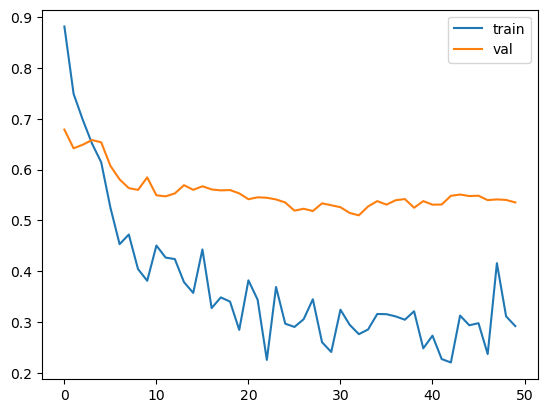

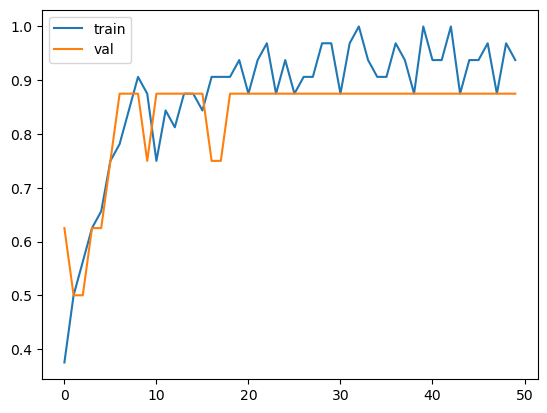

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [59]:
train_model(model, loss, optimizer, scheduler, num_epochs=50)

In [60]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'),
                os.path.join(test_dir, 'unknown'))

'test/unknown'

In [61]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths(test_dir, val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size = batch_size, shuffle=False, num_workers=batch_size)

In [62]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 93/93 [00:03<00:00, 29.87it/s]


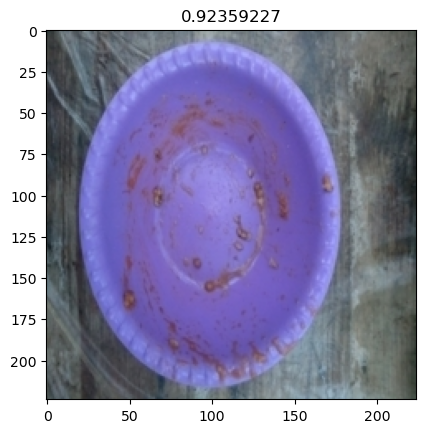

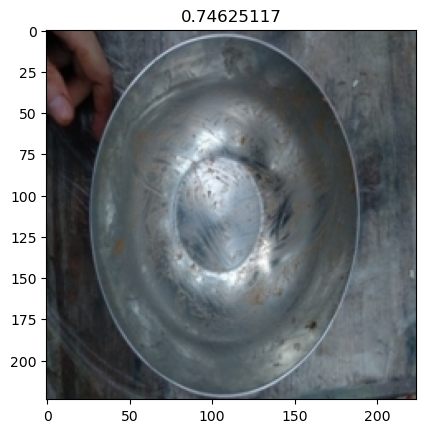

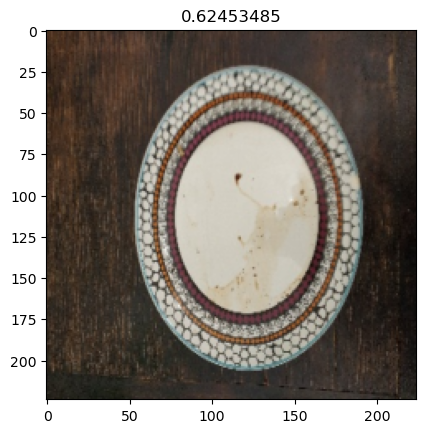

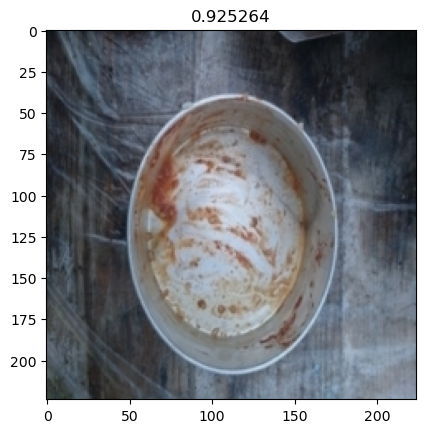

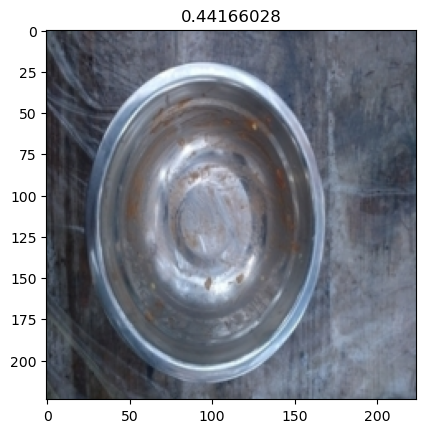

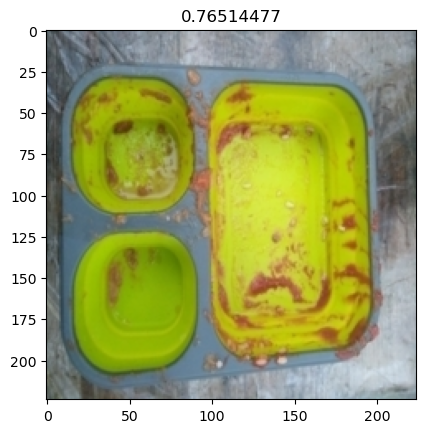

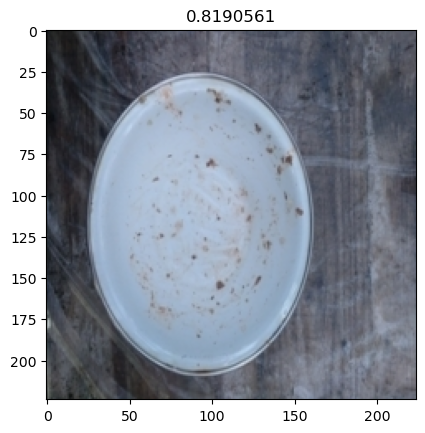

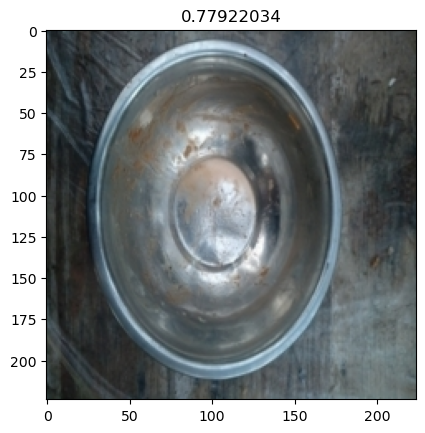

In [63]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [64]:
sub_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [65]:
sub_df['label']= sub_df['label'].map(lambda pred: 'dirty' if pred >=0.5 else 'cleaned')
sub_df['id'] = sub_df['id'].str.replace('test/unknown/', '')
sub_df['id'] = sub_df['id'].str.replace('.jpg', '')
sub_df.set_index('id', inplace=True)

/tmp/ipykernel_28/1251655581.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  sub_df['id'] = sub_df['id'].str.replace('.jpg', '')


In [66]:
sub_df.to_csv('submission.csv')

In [67]:
!rm -rf val test